In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [29]:
df_features = pd.read_csv("../data/internal/ml/features_by_year.csv")

In [30]:
def calc_threshold(df):
    returns = df["normalized_return"].to_list()
    median_return = np.median(returns)
    std_return = np.std(returns)
    threshold = median_return + (std_return * 0.2)
    return threshold


threshold = calc_threshold(df_features)

2 categories:
1. anomalous: return > mean_return + std_return
2. normal: return <= mean_return + std_return

In [31]:
df_train = df_features[df_features["year"] < 2023]
df_test = df_features[df_features["year"] >= 2023]

In [32]:
df_train["category"] = df_train["normalized_return"].apply(lambda x: 1 if x > threshold else 0)
print(len(df_train[df_train["category"] == 1]), len(df_train[df_train["category"] == 0]))

df_test["category"] = df_test["normalized_return"].apply(lambda x: 1 if x > threshold else 0)
print(len(df_test[df_test["category"] == 1]), len(df_test[df_test["category"] == 0]))

108 263
17 42


/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_75925/727332346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["category"] = df_train["normalized_return"].apply(lambda x: 1 if x > threshold else 0)
/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_75925/727332346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["category"] = df_test["normalized_return"].apply(lambda x: 1 if x > threshold else 0)


In [33]:
X_train = df_train.drop(
    [
        "name",
        "avg_return",
        "return_volatility",
        "cumulative_return",
        "start_date",
        "end_date",
        "sp500_cumulative_return",
        "normalized_return",
        "category",
        "year",
    ],
    axis=1,
)
y_train = df_train["category"]

X_test = df_test.drop(
    [
        "name",
        "avg_return",
        "return_volatility",
        "cumulative_return",
        "start_date",
        "end_date",
        "sp500_cumulative_return",
        "normalized_return",
        "category",
        "year",
    ],
    axis=1,
)
y_test = df_test["category"]

## Random Forest Classifier

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Accuracy: 0.6949152542372882

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.82        42
           1       0.33      0.06      0.10        17

    accuracy                           0.69        59
   macro avg       0.52      0.51      0.46        59
weighted avg       0.60      0.69      0.61        59



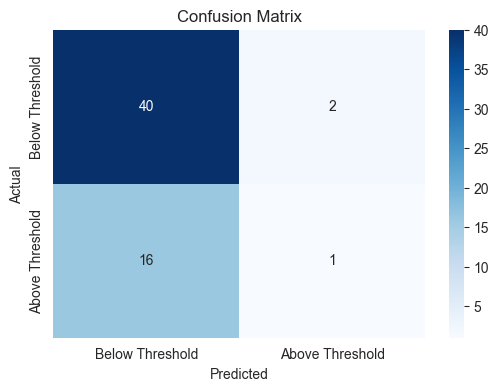

In [34]:
rf_classifier = RandomForestClassifier(random_state=42)

pipeline = Pipeline([("classifier", rf_classifier)])

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__max_features": ["sqrt", "log2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Below Threshold", "Above Threshold"],
    yticklabels=["Below Threshold", "Above Threshold"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.6949152542372882

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80        42
           1       0.45      0.29      0.36        17

    accuracy                           0.69        59
   macro avg       0.60      0.58      0.58        59
weighted avg       0.66      0.69      0.67        59



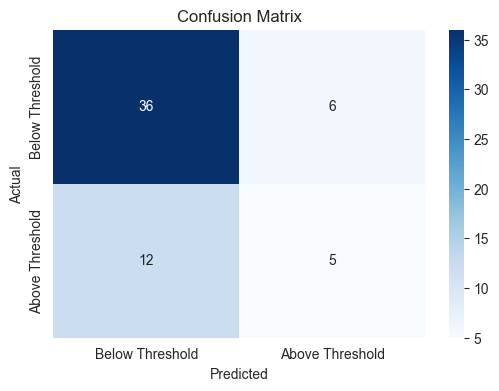

In [35]:
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0])
    / len(y_train[y_train == 1]),  # Class weight adjustment
    random_state=42,
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Below Threshold", "Above Threshold"],
    yticklabels=["Below Threshold", "Above Threshold"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.6440677966101694

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        42
           1       0.36      0.29      0.32        17

    accuracy                           0.64        59
   macro avg       0.55      0.54      0.54        59
weighted avg       0.62      0.64      0.63        59



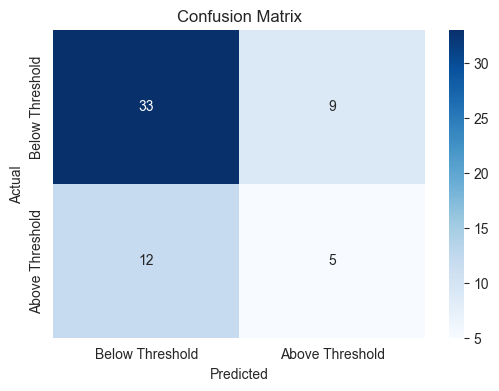

In [36]:
logreg = LogisticRegression(class_weight="balanced", random_state=42)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Below Threshold", "Above Threshold"],
    yticklabels=["Below Threshold", "Above Threshold"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()